# Mini Project on Retail Sales Data Using PySpark

## Dataset : retail_sales_dataset.csv

## Source : https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset

In [112]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Retail Sales Dataset Insights

The dataset provided contains details of **1,000 retail transactions** carried out by customers across three product categories. It has nine columns: **Transaction ID, Date, Customer ID, Gender, Age, Product Category, Quantity, Price per Unit,** and **Total Amount**. There are no missing values, ensuring completeness and reliability of the dataset. Below are the detailed insights:

### 1. Structure and Uniqueness
The dataset comprises **1,000 rows and 9 columns**. Each transaction is uniquely identified by a Transaction ID. Similarly, each customer has a unique Customer ID, ensuring one record per transaction per customer. The dataset captures both demographic attributes (gender, age) and transactional details (category, quantity, price, amount), providing a well-rounded foundation for sales analytics.

### 2. Product Categories
There are **three product categories** represented: **Beauty, Clothing,** and **Electronics**. Clothing is the most frequently purchased, followed by Beauty, while Electronics has relatively fewer but possibly high-value transactions. This indicates customer preference is skewed toward lifestyle products, though electronics may contribute more to revenue per unit.

### 3. Gender Distribution
The dataset has a fairly balanced gender split:
- **Female Customers:** 510 (51%)
- **Male Customers:** 490 (49%)

This near-equal distribution indicates that marketing strategies can be applied uniformly across genders without heavy skew.

### 4. Age Distribution
Customer ages range from **18 to 64 years**, with an average age of **41.4 years**.
- Younger customers (18–25) form a smaller share but may be associated with lower transaction values.
- Mid-aged customers (30–50) dominate the dataset, likely contributing to stable, consistent sales.
- The spread suggests that the business appeals to a broad demographic, but middle-aged buyers are the core segment.

### 5. Revenue Insights
The Total Amount (transaction revenue) ranges from **₹25 to ₹2,000**, with an average of **₹456**.
- The distribution is moderately skewed, as most transactions are of moderate value, but there are notable high-value purchases.
- Such high-value outliers are more likely linked to electronics or bulk clothing orders.
- The variability in spending suggests opportunities for customer segmentation (e.g., budget vs. premium shoppers).

### 6. Key Relationships
- **Quantity vs. Revenue:** Strong positive correlation, as expected — larger orders generate higher revenue.
- **Price vs. Revenue:** High-priced items significantly influence total transaction amounts, especially in the Electronics category.
- **Age vs. Revenue:** Middle-aged customers tend to spend more, indicating a relationship between age and purchasing power.

### 7. Business Characteristics
Overall, the dataset represents a balanced and clean retail dataset capturing customer demographics, purchasing behavior, and transaction amounts. Its completeness makes it suitable for **predictive modeling, customer segmentation,** and **revenue forecasting**. It highlights:
- Strong presence of mid-aged buyers.
- Balanced gender contribution.
- A mix of low-value frequent sales (Beauty, Clothing) and high-value occasional sales (Electronics).

In [113]:
# 1. Initialize Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, to_date, month, year, desc
spark = SparkSession.builder \
    .appName("RetailSalesAnalysis") \
    .getOrCreate()

In [114]:
# 2. Load Dataset
df = spark.read.csv("retail_sales_dataset.csv", header=True, inferSchema=True)
print("Schema:")
df.printSchema()
print("Sample Data:")
df.show(5)

Schema:
root
 |-- Transaction ID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price per Unit: integer (nullable = true)
 |-- Total Amount: integer (nullable = true)

Sample Data:
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|             1|2023-11-24|    CUST001|  Male| 34|          Beauty|       3|            50|         150|
|             2|2023-02-27|    CUST002|Female| 26|        Clothing|       2|           500|        1000|
|             3|2023-01-13|    CUST003|  Male| 50|     Electronics|  

In [115]:
# 3. Total number of records
total_records = df.count()
print(f"Total Records: {total_records}")

Total Records: 1000


In [116]:
# 4. Distinct customers
unique_customers = df.select("Customer ID").distinct().count()
print(f"Unique Customers: {unique_customers}")

Unique Customers: 1000


In [117]:
# 5. Distinct product categories
unique_categories = df.select("Product Category").distinct().count()
print(f"Unique Product Categories: {unique_categories}")

Unique Product Categories: 3


In [118]:
# 6. Gender distribution
gender_dist = df.groupBy("Gender").count().collect()
print("Gender Distribution:")
for row in gender_dist:
    print(f" {row['Gender']}: {row['count']}")

Gender Distribution:
 Female: 510
 Male: 490


In [119]:
# 7. Data Cleaning & Feature Engineering
# Convert Date column to proper DateType
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
# Add Revenue column (if not already there)
df = df.withColumn("Revenue", col("Quantity") * col("Price per Unit"))

In [120]:
# 8. Age statistics
df.selectExpr(
    "min(Age) as Min_Age",
    "max(Age) as Max_Age",
    "avg(Age) as Avg_Age"
).show()

# Revenue statistics (using Spark SQL functions)
from pyspark.sql.functions import min, max, avg

df.select(
    min("Revenue").alias("Min_Revenue"),
    max("Revenue").alias("Max_Revenue"),
    avg("Revenue").alias("Avg_Revenue")
).show()

+-------+-------+-------+
|Min_Age|Max_Age|Avg_Age|
+-------+-------+-------+
|     18|     64| 41.392|
+-------+-------+-------+

+-----------+-----------+-----------+
|Min_Revenue|Max_Revenue|Avg_Revenue|
+-----------+-----------+-----------+
|         25|       2000|      456.0|
+-----------+-----------+-----------+



In [121]:
# 9. Descriptive Statistics
df.describe(["Quantity", "Price per Unit", "Revenue"]).show()

+-------+------------------+------------------+-----------------+
|summary|          Quantity|    Price per Unit|          Revenue|
+-------+------------------+------------------+-----------------+
|  count|              1000|              1000|             1000|
|   mean|             2.514|            179.89|            456.0|
| stddev|1.1327343409145354|189.68135627129234|559.9976315551235|
|    min|                 1|                25|               25|
|    max|                 4|               500|             2000|
+-------+------------------+------------------+-----------------+



In [122]:
# Categorical Analysis
# 10 Orders by product category
df.groupBy("Product Category").agg(count("*").alias("Total Orders")).show()

+----------------+------------+
|Product Category|Total Orders|
+----------------+------------+
|     Electronics|         342|
|        Clothing|         351|
|          Beauty|         307|
+----------------+------------+



In [123]:
# 11. Orders by gender
gender_stats=df.groupBy("Gender").agg(count("*").alias("Orders"))
print("Orders by Gender:")
gender_stats.show()

Orders by Gender:
+------+------+
|Gender|Orders|
+------+------+
|Female|   510|
|  Male|   490|
+------+------+



In [124]:
# 12. Revenue by category
category_stats=df.groupBy("Product Category") \
  .agg(sum("Revenue").alias("Total Revenue"), avg("Revenue").alias("Avg Revenue")) \
  .orderBy(desc("Total Revenue"))
print("Revenue by Product Category:")
category_stats.show()
cat_pd = category_stats.toPandas()

Revenue by Product Category:
+----------------+-------------+-----------------+
|Product Category|Total Revenue|      Avg Revenue|
+----------------+-------------+-----------------+
|     Electronics|       156905|458.7865497076023|
|        Clothing|       155580|443.2478632478632|
|          Beauty|       143515|467.4755700325733|
+----------------+-------------+-----------------+



In [125]:
# 13. Time Series Analysis (Monthly)
monthly_trend=df.groupBy(year("Date").alias("Year"), month("Date").alias("Month")) \
  .agg(sum("Revenue").alias("Monthly Revenue"), count("*").alias("Orders")) \
  .orderBy("Year","Month")
trend_pd = monthly_trend.toPandas()
trend_pd["Month_Label"] = trend_pd["Year"].astype(str) + "-" + trend_pd["Month"].astype(str)

In [126]:
# 14. High-Value Transactions
avg_revenue = df.agg(avg("Revenue")).collect()[0][0]
high_value = df.filter(col("Revenue") > avg_revenue)
print("High Value Records (> Average Revenue):")
high_value.show(10)

High Value Records (> Average Revenue):
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+-------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|Revenue|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+-------+
|             2|2023-02-27|    CUST002|Female| 26|        Clothing|       2|           500|        1000|   1000|
|             4|2023-05-21|    CUST004|  Male| 37|        Clothing|       1|           500|         500|    500|
|             9|2023-12-13|    CUST009|  Male| 63|     Electronics|       2|           300|         600|    600|
|            13|2023-08-05|    CUST013|  Male| 22|     Electronics|       3|           500|        1500|   1500|
|            15|2023-01-16|    CUST015|Female| 42|     Electronics|       4|           500|        2000|   2000|
|            16|2023-02-17|    CUST016|  Male| 19|      

In [127]:
# 15. Save results to file
spark = SparkSession.builder \
    .appName("RetailSalesProject") \
    .config("spark.hadoop.io.nativeio.enabled", "false") \
    .getOrCreate()
#  Filter high-value transactions
avg_revenue = df.agg(avg("Revenue")).first()[0]
print(f"Average Revenue in Dataset = {avg_revenue:.2f}")

high_value_df = df.filter(col("Revenue") > avg_revenue)

# Save results to file
output_path = "file:///C:/Users/bhava/OneDrive/Desktop/BDAMiniProject/HighValue_Transactions"

try:
    # Save as a single CSV with header
    high_value_df.coalesce(1) \
        .write.option("header", True) \
        .mode("overwrite") \
        .csv(output_path)
    print(f"✅ Saved high-value transactions into: {output_path}")
except Exception as e:
    print(" Spark CSV write failed, using Pandas fallback...")
    high_value_df.toPandas().to_csv(
        "C:/Users/bhava/OneDrive/Desktop/MiniProject/HighValue_Transactions.csv",
        index=False
    )
    print(" Saved high-value transactions using Pandas fallback.")

Average Revenue in Dataset = 456.00
✅ Saved high-value transactions into: file:///C:/Users/bhava/OneDrive/Desktop/BDAMiniProject/HighValue_Transactions


In [128]:
# 16. Filter Customers below Age 25
young_customers_df = df.filter(col("Age") < 25)
output_path = "file:///C:/Users/bhava/OneDrive/Desktop/BDAMiniProject/Customers_Below_25"
try:
    young_customers_df.coalesce(1) \
        .write.option("header", True) \
        .mode("overwrite") \
        .csv(output_path)
    print(f"✅ Saved Customers Below 25 into: {output_path}")

except Exception as e:
    print(" Spark CSV write failed, using Pandas fallback...")
    young_customers_df.toPandas().to_csv(
        "C:/Users/bhava/OneDrive/Desktop/BDAMiniProject/Customers_Below_25.csv",
        index=False
    )
    print(" Saved Customers Below 25 using Pandas fallback.")

✅ Saved Customers Below 25 into: file:///C:/Users/bhava/OneDrive/Desktop/BDAMiniProject/Customers_Below_25


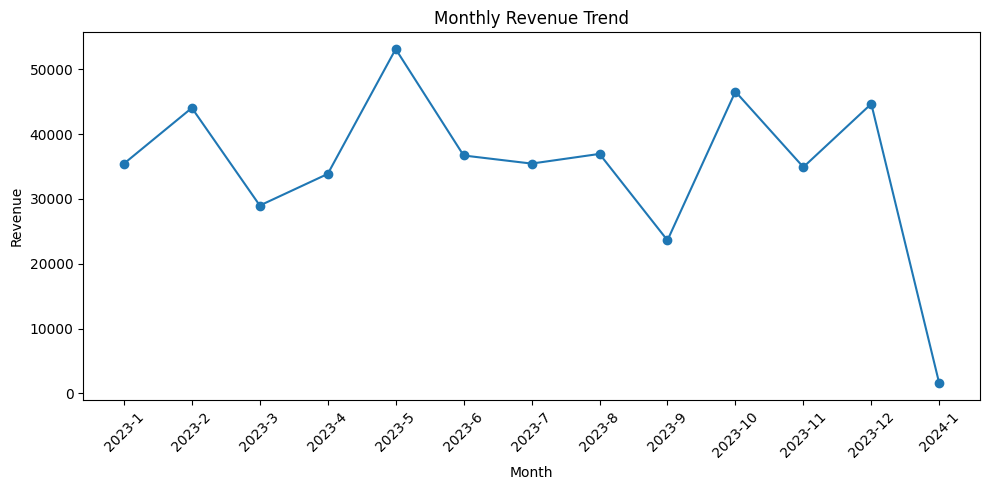

In [129]:
# Visualizations
# 1.Line Chart: Monthly Revenue Trend
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(trend_pd["Month_Label"], trend_pd["Monthly Revenue"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

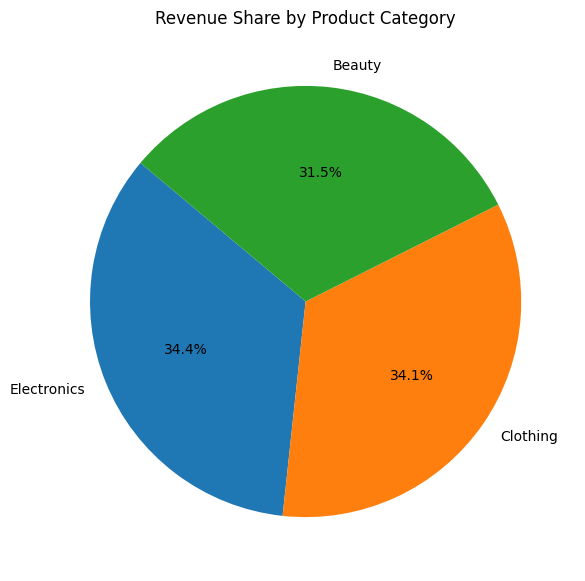

In [130]:
# 2.Pie Chart: Revenue by Product Category
plt.figure(figsize=(7,7))
plt.pie(
    cat_pd["Total Revenue"],
    labels=cat_pd["Product Category"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Revenue Share by Product Category")
plt.show()

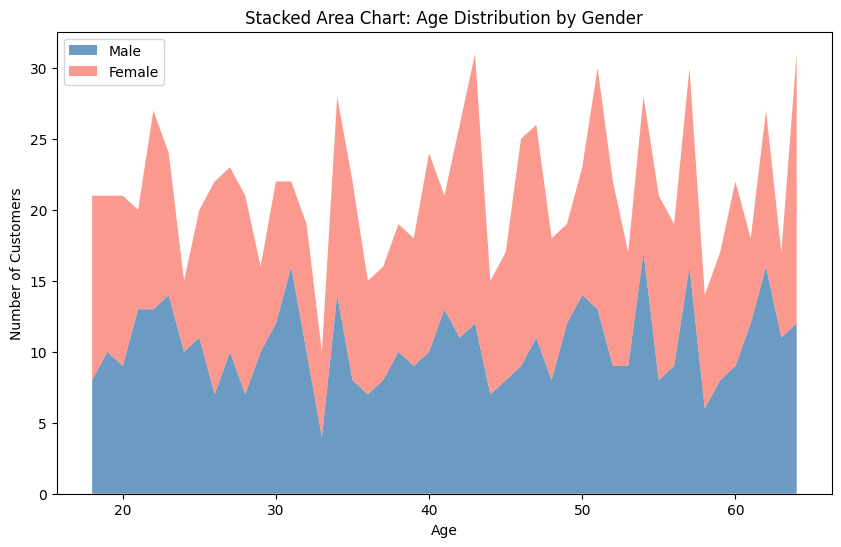

In [131]:
# 3.Stacked Area Chart: Age Distribution by Gender
age_gender = df.groupBy("Age", "Gender").count()
age_gender_pd = age_gender.toPandas().pivot(index="Age", columns="Gender", values="count").fillna(0)
plt.figure(figsize=(10,6))
plt.stackplot(
    age_gender_pd.index,
    age_gender_pd["Male"],
    age_gender_pd["Female"],
    labels=["Male", "Female"],
    colors=["steelblue", "salmon"],
    alpha=0.8
)
plt.title("Stacked Area Chart: Age Distribution by Gender")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

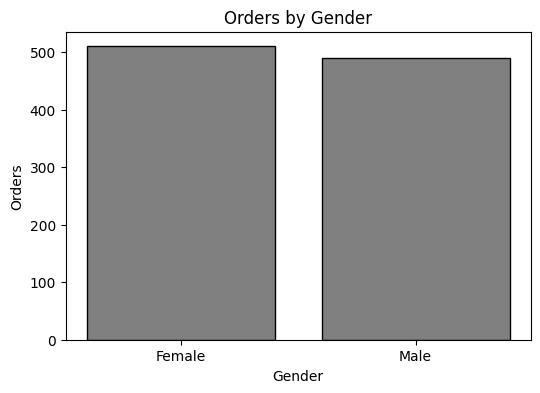

In [132]:
# 4.Bar Chart: Orders by Gender
gender_pd = gender_stats.toPandas()
plt.figure(figsize=(6,4))
plt.bar(gender_pd["Gender"], gender_pd["Orders"], color="gray", edgecolor="black")
plt.title("Orders by Gender")
plt.xlabel("Gender")
plt.ylabel("Orders")
plt.show()

<Figure size 800x500 with 0 Axes>

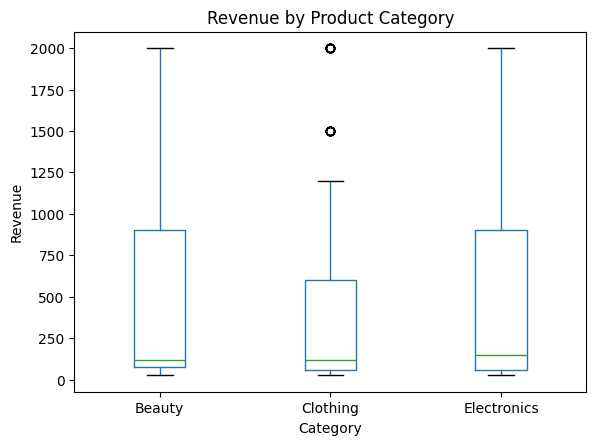

In [133]:
# 5.Boxplot: Revenue by Product Category
box_pd = df.select("Product Category","Revenue").toPandas()
plt.figure(figsize=(8,5))
box_pd.boxplot(column="Revenue", by="Product Category", grid=False)
plt.title("Revenue by Product Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()

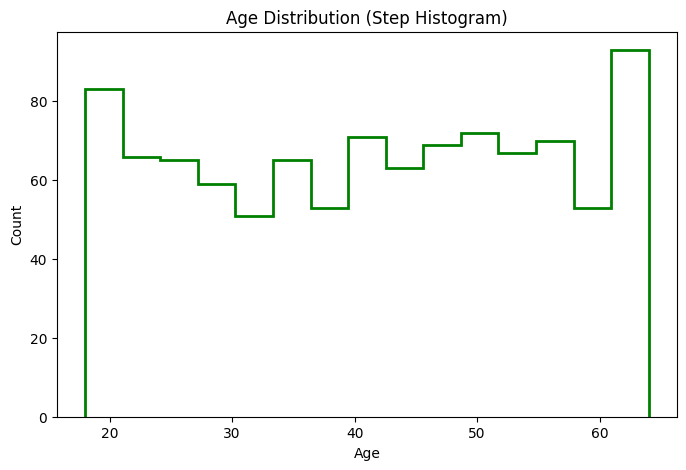

In [134]:
# 6.Histogram: Age Distribution
age_pd = df.select("Age").toPandas()
plt.figure(figsize=(8,5))
plt.hist(age_pd["Age"], bins=15, histtype="step", linewidth=2, color="green")
plt.title("Age Distribution (Step Histogram)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

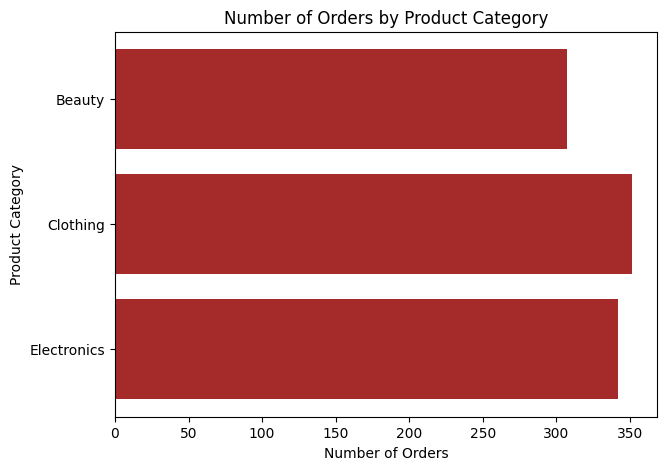

In [135]:
# 7.Horizontal Bar Chart: Orders by Product Category
category_count = df.groupBy("Product Category").count().toPandas()
plt.figure(figsize=(7,5))
plt.barh(category_count["Product Category"], category_count["count"], color="brown")
plt.title("Number of Orders by Product Category")
plt.xlabel("Number of Orders")
plt.ylabel("Product Category")
plt.show()

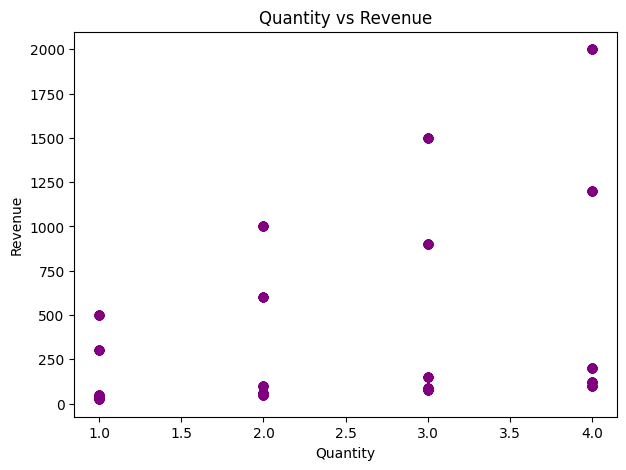

In [136]:
# 8.Scatter Plot: Quantity vs Revenue
scatter_pd = df.select("Quantity", "Revenue").toPandas()
plt.figure(figsize=(7,5))
plt.scatter(scatter_pd["Quantity"], scatter_pd["Revenue"], alpha=0.5, color="purple")
plt.title("Quantity vs Revenue")
plt.xlabel("Quantity")
plt.ylabel("Revenue")
plt.show()

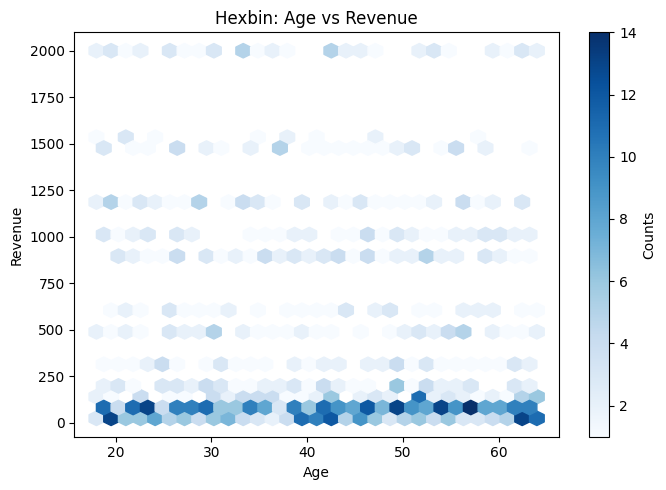

In [137]:
# 9.Hexbin: Age vs Revenue
num_pd = df.select("Age", "Revenue").toPandas()
plt.figure(figsize=(7,5))
hb = plt.hexbin(num_pd["Age"], num_pd["Revenue"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(hb, label="Counts")
plt.title("Hexbin: Age vs Revenue")
plt.xlabel("Age")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

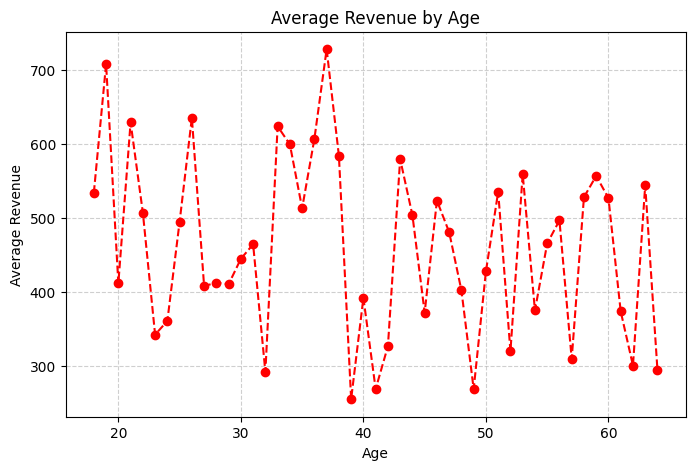

In [138]:
# 10.Line Plot: Average Revenue by Age
avg_rev_age = df.groupBy("Age").agg(avg("Revenue").alias("AvgRevenue")).orderBy("Age").toPandas()
plt.figure(figsize=(8,5))
plt.plot(avg_rev_age["Age"], avg_rev_age["AvgRevenue"], marker="o", linestyle="--", color="red")
plt.title("Average Revenue by Age")
plt.xlabel("Age")
plt.ylabel("Average Revenue")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Conclusion

The Retail Sales project successfully applied **PySpark and data analytics techniques** to a retail sales dataset of 1,000 transactions.  Through systematic exploration and visualization, we uncovered key business insights:
The results highlight opportunities to target **mid-aged premium buyers** while engaging younger customers through promotions, ensuring sustainable growth. This retail sales dataset reveals a balanced customer base by gender and a **strong mid-aged segment (30–50 years)** driving the majority of revenue. Clothing contributes most transactions, while **Electronics generate high-value purchases**, highlighting opportunities for differentiated marketing. Overall, the dataset is clean, consistent, and provides a solid foundation for **customer segmentation, trend forecasting,** and **targeted business strategies**.
